In [23]:
import torch
from torchvision import models, transforms
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [24]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet50.eval()  # Set the model to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
# Define a function to add Gaussian noise to a tensor
def add_gaussian_noise(image_tensor, mean=0.0, std=0.05):
    noise = torch.randn_like(image_tensor) * std + mean  # Generate Gaussian noise
    noisy_image = image_tensor + noise  # Add noise to the image
    return torch.clamp(noisy_image, 0.0, 1.0)  # Clamp to ensure pixel values are valid

In [26]:
preprocess = transforms.Compose([
    transforms.Resize(256),        # Resize the image to 256x256 pixels
    transforms.CenterCrop(224),    # Center crop to 224x224 pixels
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(          # Normalize using ImageNet's mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

image_folder = 'images/'  # Folder containing images
image_files = os.listdir(image_folder)[:10]  # Adjust to get exactly 10 images
print(image_files)

ground_truth_labels = [1, 1, 51, 51, 99, 99, 742, 742, 963, 963]

['001_goldfish_1.jpg', '001_goldfish_2.jpg', '051_triceratops_1.png', '051_triceratops_2.jpeg', '099_goose_1.jpg', '099_goose_2.jpg', '742_printer_1.png', '742_printer_2.jpeg', '963_pizza_1.jpg', '963_pizza_2.jpg']


In [27]:
images = []
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    image = add_gaussian_noise(image)  # Add Gaussian noise
    images.append(image)

images = torch.stack(images)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = images.to(device)
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
with torch.no_grad():
    outputs = resnet50(images)
    _, predicted_classes = outputs.max(1)

In [29]:
predicted_classes = predicted_classes.cpu().numpy()  # Convert to numpy for metrics
ground_truth_labels = np.array(ground_truth_labels)
print(predicted_classes)

[  1   1 275  51  83 134 549 499 443 963]


In [41]:
# Accuracy
accuracy = accuracy_score(ground_truth_labels, predicted_classes)

# Precision, Recall, F1-score
precision = precision_score(ground_truth_labels, predicted_classes, average='weighted', zero_division=1)
recall = recall_score(ground_truth_labels, predicted_classes, average='weighted', zero_division=1)
f1 = f1_score(ground_truth_labels, predicted_classes, average='weighted', zero_division=1)

# Confusion Matrix
all_classes = sorted(set(ground_truth_labels) | set(predicted_classes))

conf_matrix = confusion_matrix(ground_truth_labels, predicted_classes, labels=all_classes)



<class 'list'>


In [31]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.40
Precision: 1.00
Recall: 0.40
F1-score: 0.47


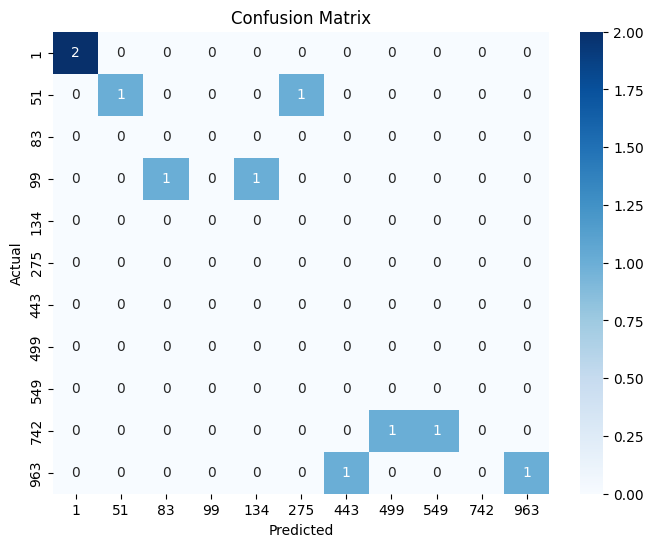

In [43]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=all_classes, yticklabels=all_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("confusion matrix noised.jpg")
plt.show()